## Exploring and Denoising Your Data Set

To train a model, the data set must follow two fundamental rules: all data must be numeric and there can't be any missing values. We must derive numeric features from the nonnumeric features such as strings, dates and categorical variables. In this chapter, we'll stick with the numeric fields (bathrooms, bedrooms, longitude, latitude) we used before. Even with purely numeric data, there is potential cleanup work to do. The data could have outliers, errors, or contradictory information. For example, in our apartment data, one place claims to have 2 bedrooms but 10 bathrooms, while other apartments claim to be on the equator!

### Getting a quick sniff of the data

We need to know what the data looks like so our first inspection of the data should yield the column names their datatypes, and whether the target column has numeric values or categories. (If we're creating a regressor, those values must be numeric; if we're classifying, those values must be categories.)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

# sets the size of plots in inches (1 inch = 2.54cm)
plt.rcParams["figure.figsize"] = (20, 7)
# sets the theme for plots to dark
plt.style.use('dark_background')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
df = pd.read_csv("../data/rent.csv")

# print rows, columns
print(df.shape)
# dump first 3 rows
df.head(3)  

(49352, 15)


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"['Dining Room', 'Pre-War', 'Laundry in Buildin...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,['https://photos.renthop.com/2/7170325_3bb5ac8...,2400,145 Borinquen Place,medium
1,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"['Doorman', 'Elevator', 'Laundry in Building',...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,['https://photos.renthop.com/2/7092344_7663c19...,3800,230 East 44th,low
2,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"['Doorman', 'Elevator', 'Laundry in Building',...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,['https://photos.renthop.com/2/7158677_c897a13...,3495,405 East 56th Street,medium


In [3]:
# there are many columns and some of them are very wide 
# so, let's transpose the display so that the columns are vertical
df.head(2).T

,0,1
bathrooms,1,1
bedrooms,1,2
building_id,8579a0b0d54db803821a35a4a615e97a,b8e75fc949a6cd8225b455648a951712
created,2016-06-16 05:55:27,2016-06-01 05:44:33
description,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...
display_address,145 Borinquen Place,East 44th
features,"['Dining Room', 'Pre-War', 'Laundry in Buildin...","['Doorman', 'Elevator', 'Laundry in Building',..."
latitude,40.7108,40.7513
listing_id,7170325,7092344
longitude,-73.9539,-73.9722


In [4]:
# pandas can tell us more specifically about the data types if we ask for info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49352 entries, 0 to 49351
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      47906 non-null  object 
 5   display_address  49217 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49342 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 5.6+ MB


The datatypes are in the last column, such as **float64** which means “floating-point number using 64-bits(8 bytes) of memory”. The object data type is pandas' equivalent of a string datatype. Anything other than float and int are nonnumeric datatypes. Because we don't know how to deal with nonnumeric datatypes at this point, we can just drop those columns. All we care about are the numeric fields: bathrooms, bedrooms, longitude, latitude, price.

In [5]:
"""
Data frame df_numeric acts like a copy of df with just those five columns but df_numeric is actually a view or perspective of df restricted to five columns.
"""

# get subset of all columns
df_numeric = df[['bathrooms', 'bedrooms', 'longitude', 'latitude', 'price']]
df_numeric.head(5)

,bathrooms,bedrooms,longitude,latitude,price
0,1.0,1,-73.9539,40.7108,2400
1,1.0,2,-73.9722,40.7513,3800
2,1.0,2,-73.9625,40.7575,3495
3,1.5,3,-73.9425,40.7145,3000
4,1.0,0,-73.9743,40.7439,2795


In [6]:
# because models cannot handle missing values, 
# another standard check is to see if there are missing values in the data set
df_numeric.isnull().any()

bathrooms    False
bedrooms     False
longitude    False
latitude     False
price        False
dtype: bool

### Training and evaluating an initial model

In [7]:
# separate the features and target columns.
X_train = df_numeric.drop('price', axis=1)
y_train = df_numeric['price']

# create an appropriate model with suitable hyper-parameters.
random_forest = RandomForestRegressor(n_estimators=100, n_jobs=-1)

# fit model to the training data.
random_forest.fit(X_train, y_train);

In [8]:
# let's get a measure of how well the model fits the training data using score()
# which returns R^2
r2 = random_forest.score(X_train, y_train)
print( f"{r2:.4f}" )

0.8511


A perfect training $R^2$ score is 1.0, meaning that the model perfectly recalls the training data. An score of 0 means the model performs no better than always just returning the average price. Unfortunately, a high training  score (low error) doesn't tell us much. A high score just means that it's possible there is a relationship between features and target and captured by the model. If, however, we can't get a high  score, it's an indication that there is no relationship or the model is simply unable to capture it. Just remember that 1.0 means perfect and 0.0 means no better than returning the average value.

Another reason to favor RFs, is that they can efficiently estimate the prediction error while training the model, completely avoiding the need for separate validation sets. The error score is called the out-of-bag score and  is the typical metric computed. (Bag is an abbreviation of bootstrap aggregation). Recall that RFs are a collection of decision trees, each of which is trained on a subset of the training data. The out-of-bag (OOB) score looks at the prediction accuracy for a particular record using only those trees that did not train on that record. Statisticians have shown that the out-of-bag score gives an excellent estimate of a model's generality, its true prediction error.

In [9]:
# train the model and estimate the error using OOB score
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)

# show the error
noisy_oob_r2 = rf.oob_score_
print(f"OOB score {noisy_oob_r2:.4f}")

OOB score -0.0709


That score is terrible, approximately as bad as just predicting the average apartment rent price. Given the strength of RFs, poor performance could indicate there is little to no relationship to capture between apartment characteristics and rent price, or it could mean the data is inconsistent or has outliers.

### Exploring and denoising the apartment rent data

The general concept of exporing data around is called exploratory data analysis (EDA). We're going to explore the data with the explicit purpose of finding anomalies. The focus of our model is on typically-priced apartments and only within New York City proper, which means we're going to look for extreme rent values and apartments outside of New York City.

In [10]:
# let's describe the data set
df_numeric.describe()

,bathrooms,bedrooms,longitude,latitude,price
count,49352.00000,49352.000000,49352.000000,49352.000000,4.935200e+04
mean,1.21218,1.541640,-73.955716,40.741545,3.830174e+03
std,0.50142,1.115018,1.177912,0.638535,2.206687e+04
min,0.00000,0.000000,-118.271000,0.000000,4.300000e+01
25%,1.00000,1.000000,-73.991700,40.728300,2.500000e+03
50%,1.00000,1.000000,-73.977900,40.751800,3.150000e+03
75%,1.00000,2.000000,-73.954800,40.774300,4.100000e+03
max,10.00000,8.000000,0.000000,44.883500,4.490000e+06


A number of anomalies pop out from the minimum and maximum for each column. There's a place with 10 bathrooms and another with 8 bedrooms. There is a reference to longitude 0, which is the prime meridian (Greenwich, England), and a reference to latitude zero, the equator. Oh, and let's not forget the apartment that costs \$4,490,000 per month or the intriguing place that costs \$43 per month.

For the apartment data, it's safe to say that an apartment for less than \$1,000 in New York City is probably missing some key elements like windows and doors, so that should be our lowest price. At the high-end, let's call $10,000 outside the range of "reasonably priced."

#### Examining the data distributions

In [11]:
# it looks like there are a number of very expensive apartments 
# values that are very different in magnitude from the others 
# in the feature or target space (range) are called outliers
print(df_numeric.price.sort_values(ascending=False).head(10))

12947    4490000
4793     1150000
22968    1070000
22058    1070000
49289     135000
1830      111111
36476     100000
21525      90000
46382      85000
38564      80000
Name: price, dtype: int64


In [12]:
# it looks like there are only a few outlier apartments 
# listed as having more than six bathrooms 
# and only a few having more than six bedrooms
display(df_numeric.bathrooms.value_counts(), df_numeric.bedrooms.value_counts())

1.0     39422
2.0      7660
3.0       745
1.5       645
0.0       313
2.5       277
4.0       159
3.5        70
4.5        29
5.0        20
5.5         5
6.0         4
10.0        1
6.5         1
7.0         1
Name: bathrooms, dtype: int64

1    15752
2    14623
0     9475
3     7276
4     1929
5      247
6       46
8        2
7        2
Name: bedrooms, dtype: int64

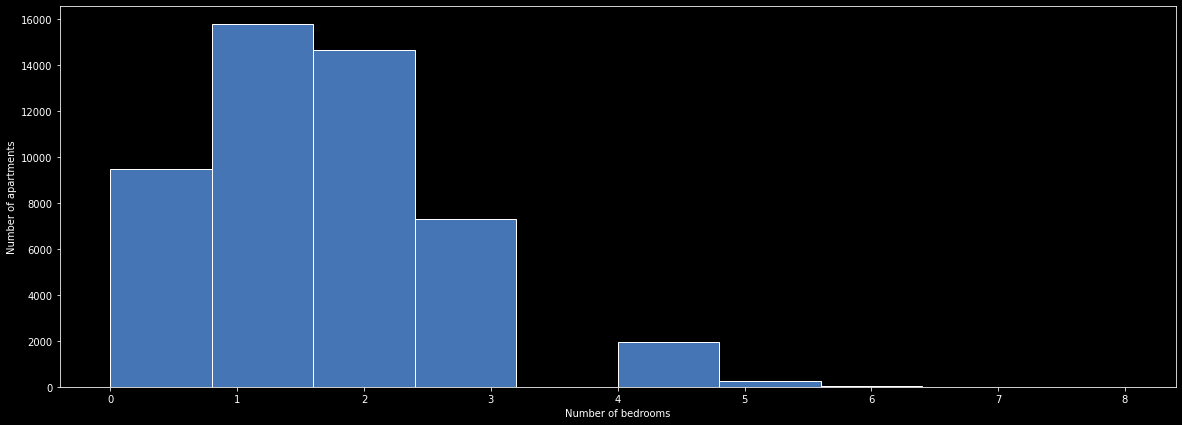

In [13]:
color_palette = {
'crimson': '#a50026', 
'red': '#d73027',
'redorange': '#f46d43', 
'orange': '#fdae61',
'yellow': '#fee090', 
'sky': '#e0f3f8',
'babyblue': '#abd9e9', 
'lightblue': '#74add1',
'blue': '#4575b4', 
'purple': '#313695'
}

# number of apartments per number of bedrooms
figure, subplot = plt.subplots()
subplot.set_xlabel('Number of bedrooms')
subplot.set_ylabel('Number of apartments')
subplot.hist(df_numeric.bedrooms, color=color_palette['blue'], edgecolor='white')
plt.show()

Noise and outliers are potential problems because they can lead to inconsistencies. An inconsistency is a set of similar or identical feature vectors with much different target values. For example, if we zero in on the region of New York City containing two apartments over $1,000,000, we see other apartments with the same characteristics but with reasonable prices.



In [14]:
df_local = df[(df.latitude>40.764) & (df.latitude<40.7678) &
              (df.longitude>=-73.9844) & (df.longitude<=-73.9842) &
           (df.bathrooms==1) & (df.bedrooms==1)]
df_local[['bedrooms','bathrooms','street_address','price']].sort_values('price')

,bedrooms,bathrooms,street_address,price
31301,1,1.0,west 54 st & 8 ave,2300
14887,1,1.0,300 West 55th Street,2400
9153,1,1.0,300 West 55th Street,3350
38815,1,1.0,300 West 55th Street,3400
22058,1,1.0,333 West 57th Street,1070000
22968,1,1.0,333 West 57th Street,1070000


#### Removing the anomalies

We can either leave noisy or outlier records as-is, delete, or "fix" the records.

In [15]:
# filter all records (training/testing)
df_clean = df_numeric[(df_numeric.price>1_000) & (df_numeric.price<10_000)]

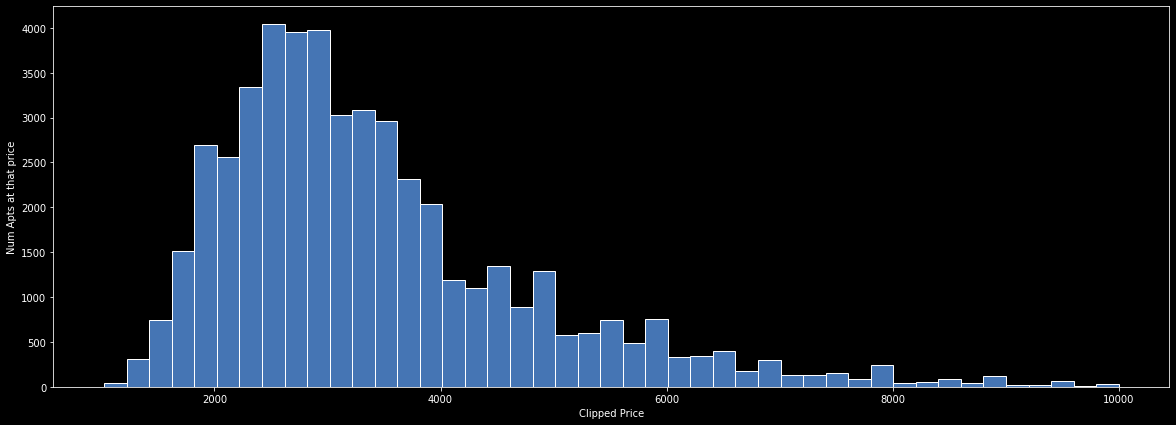

In [16]:
# draw a histogram of prices after clipping them
fig, subplot = plt.subplots()
subplot.set_xlabel('Clipped Price')
subplot.set_ylabel('Num Apts at that price')
subplot.hist(df_clean.price, bins=45, color=color_palette['blue'], edgecolor='white')
plt.show()

It's always best to use domain knowledge when identifying outliers, but if we are uncertain about an appropriate range, we can always clip out the bottom and top 1% using a bit of NumPy code.

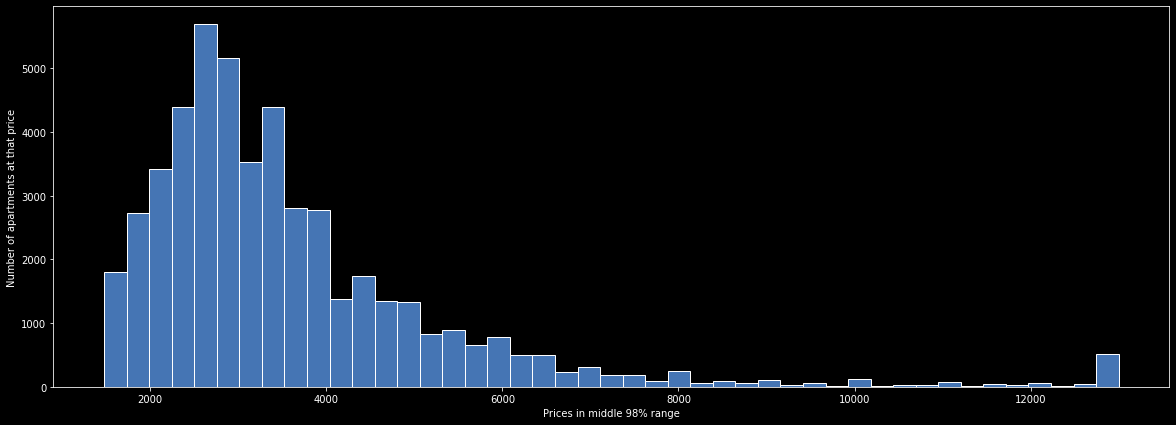

In [17]:
# find middle 98% of prices
upper, lower = np.percentile(df.price, [1,99])
clipped = np.clip(df.price, upper, lower)

# draw 98% of prices
# very similar to the upper distribution
figure, axes = plt.subplots()
axes.set_xlabel('Prices in middle 98% range')
axes.set_ylabel('Number of apartments at that price')
axes.hist(clipped, bins=45, color=color_palette['blue'], edgecolor='white')
plt.show()

In [18]:
# keep only apartments in the area around New York
# stripping these records is “legal” because they don't fit 
# within the goal previously established for the model
df_clean = df_clean[(df_clean['latitude']>40.55) &
                    (df_clean['latitude']<40.94) &
                    (df_clean['longitude']>-74.1) &
                    (df_clean['longitude']<-73.67)]

The next step could be to examine the few records with extreme numbers of bedrooms or bathrooms, but there are so few, it's unlikely they would skew the data set. This is particularly true after we've removed price outliers, so let's leave those records as-is.

### Comparing models trained on denoised data

In [19]:
# we're ready to train a model on this denoised data set to see if the model performance has improved
X, y = df_clean.drop('price', axis=1), df_clean['price']

rf = RandomForestRegressor(n_estimators=100,
                           n_jobs=-1,        # parallelize
                           oob_score=True)   # get error estimate
rf.fit(X, y)

clean_oob_r2 = rf.oob_score_
print(f"Validation OOB score {clean_oob_r2:.4f}")

Validation OOB score 0.8681


Great! We've now got a prediction model that gets a decent $R^2$ estimated prediction error. 

Transforming the target variable (using the mathematical log function) into a tighter, more uniform space makes life easier for any model. During training, RFs combine the prices of identical or nearly-identical apartments by averaging them together, thus, forming the prediction for those apartments. But, outlier prices wildly skew average prices, so the model's predictions could be very far off. We need to shrink large values a lot and smaller values a little (to fight with ourliers). That magic operation is called the **logarithm** or _log_ for short.

In [20]:
df_local = df[(df.latitude>40.764) & (df.latitude<40.7678) &
              (df.longitude>=-73.9844) & (df.longitude<=-73.9842) &
           (df.bathrooms==1) & (df.bedrooms==1)]
df_local = df_local[['bedrooms','bathrooms','street_address','price']].sort_values('price')
df_local['log(price)'] = np.log(df_local['price'])

display(df_local)
print('Average (prediction) of similar apartments on normal scale: ', np.mean(df_local['price']))
print('Average (prediction) of similar apartments on log scale: ', np.mean(df_local['log(price)']))

,bedrooms,bathrooms,street_address,price,log(price)
31301,1,1.0,west 54 st & 8 ave,2300,7.740664
14887,1,1.0,300 West 55th Street,2400,7.783224
9153,1,1.0,300 West 55th Street,3350,8.116716
38815,1,1.0,300 West 55th Street,3400,8.131531
22058,1,1.0,333 West 57th Street,1070000,13.883169
22968,1,1.0,333 West 57th Street,1070000,13.883169


Average (prediction) of similar apartments on normal scale:  358575.0
Average (prediction) of similar apartments on log scale:  9.923078861092137
